In [1]:
import pandas as pd
import numpy as np
import glob
import re

In [2]:
getDistrict = lambda x : re.findall(r'___\w+___', x)[0][3: -3]

In [3]:
condominiums = glob.glob('files/rents/DOF__Condominium_Comparable_Rental_Income*')
cooperatives = glob.glob('files/rents/DOF__Cooperative_Comparable_Rental_Income*')
sales = glob.glob('files/sales/DOF*')

In [4]:
condominiums_indx = [4, 5, 9, 11, 12, 14]
cooperatives_indx = [3, 4, 8, 10, 11, 13]
sales_indx = [1, 3, 6]

In [5]:
def getDF(files, columns, rename_columns=True):
    df = pd.DataFrame()
    for f in files:
        df_tmp = pd.read_csv(f)[columns]
        if rename_columns:
            df_tmp.columns = ['Building Classification', 'Total Units', 'Gross Income per SqFt',
                              'Expense per SqFt', 'Net Operating Income', 'Market Value per SqFt']
        df_tmp.insert(0, 'District', ' '.join(getDistrict(f).split('_')))
        df = df.append(df_tmp, ignore_index=True)
        del(df_tmp)
    
    return df

### В каких из районов Нью-Йорка наиболее выгодно сдавать жилье в аренду, и какой это тип жилья? Вывести топ-10 вариантов

In [6]:
df_condominiums = getDF(condominiums, condominiums_indx)
df_cooperatives = getDF(cooperatives, cooperatives_indx)

In [7]:
df_cooperatives.insert(1, 'Type', 'Cooperative')
df_condominiums.insert(1, 'Type', 'Condominium')

In [8]:
df_rents = df_condominiums.append(df_cooperatives)

In [9]:
df_rents.head()

,District,Type,Building Classification,Total Units,Gross Income per SqFt,Expense per SqFt,Net Operating Income,Market Value per SqFt
0,Manhattan,Condominium,R9-CONDOMINIUM,42,36.51,9.37,990610,200.00
1,Manhattan,Condominium,R4-CONDOMINIUM,78,52.47,13.94,4870962,242.76
2,Manhattan,Condominium,RR-CONDOMINIUM,500,31.24,6.39,13767000,164.15
3,Manhattan,Condominium,R4-CONDOMINIUM,282,47.28,11.18,8991643,271.23
4,Manhattan,Condominium,R4-CONDOMINIUM,239,45.58,12.68,7221385,247.48


Для подсчета выгоды нам нужно знать цены за кв. футы, налоги на кв. футы и издержки на кв. футы. Тем самым, вычитая из стоимости налог и издержки, получим чистую прибыль за кв. фут. Цены берутся за кв. фут, т.к. это нормализованные цены.

In [10]:
df_rnts_profit = df_rents[[0, 1]]
df_rnts_profit.insert(2, 'Profit', np.sum(df_rents.values[:, [4, 5, 7]].astype(np.float) * [-1, -1, 1], axis=1))

Группируем по району и типу жилья и считаем средний доход

In [11]:
gb_df = df_rnts_profit.groupby(('District', 'Type'))

In [12]:
mean_price = gb_df.mean()
mean_price

Profit
District      Type                   
Bronx         Condominium   27.056667
              Cooperative   13.941793
Brooklyn      Condominium   52.237699
              Cooperative   30.579922
Manhattan     Condominium  134.179551
              Cooperative  104.682119
Queens        Condominium   51.494217
              Cooperative   24.393900
Staten Island Condominium   21.935769
              Cooperative   14.248462

Сортируем по доходу и выводим с индексацией с 1

In [13]:
top10 = mean_price.sort_values('Profit', ascending=False).reset_index()
top10.index += 1
top10

,District,Type,Profit
1,Manhattan,Condominium,134.179551
2,Manhattan,Cooperative,104.682119
3,Brooklyn,Condominium,52.237699
4,Queens,Condominium,51.494217
5,Brooklyn,Cooperative,30.579922
6,Bronx,Condominium,27.056667
7,Queens,Cooperative,24.393900
8,Staten Island,Condominium,21.935769
9,Staten Island,Cooperative,14.248462
10,Bronx,Cooperative,13.941793


### Какие сделки по купле/продаже недвижимости являются наиболее массовыми для каждого из районов? Нанести на карту преобладающий тип сделок и отдельно медианную сумму сделок. 

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clrs
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as path_effects

from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [15]:
plt.rcParams['figure.figsize'] = (20, 10)

Создаем basemap в районе Нью-Йорка

In [16]:
m = Basemap(projection='lcc', lat_0=40.77, lon_0=-73.98,
    resolution = 'f', area_thresh = 0.1,
    llcrnrlon=-73.98 - 0.4, llcrnrlat=40.77 - 0.35,
    urcrnrlon=-73.98 + 0.5, urcrnrlat=40.77 + 0.2, ellps='GRS80')

In [17]:
df_sales = getDF(sales, sales_indx, False)

df_sales['TYPE OF HOME'] = [int(i[:2]) for i in df_sales[[1]].values[:, 0]]
df_sales['MEDIAN SALE PRICE'] = [float(i[1:]) for i in df_sales[[3]].values[:, 0]]

In [18]:
df_sales.head()

,District,TYPE OF HOME,NUMBER OF SALES,MEDIAN SALE PRICE
0,Manhattan,2,2,2872500
1,Manhattan,3,1,3800000
2,Manhattan,1,1,7926432
3,Manhattan,2,2,3892500
4,Manhattan,3,1,2400000


Группируем по районам и типу домов и считаем количество продаж

In [19]:
gb_dfs = df_sales.groupby(('District', 'TYPE OF HOME'))

In [20]:
gb_dfs_nos_sum = gb_dfs[['NUMBER OF SALES']].sum().reset_index()
gb_dfs[['NUMBER OF SALES']].sum()

NUMBER OF SALES
District      TYPE OF HOME                 
Bronx         1                         516
              2                         771
              3                         276
Brooklyn      1                        1394
              2                        2375
              3                         841
Manhattan     1                          55
              2                          47
              3                          33
Queens        1                        4714
              2                        3402
              3                         605
Staten Island 1                        2214
              2                         893
              3                          24

Находим аргмаксимумы количества продаж и по ним находим тип продаж

In [21]:
gb_dfs_formax = gb_dfs_nos_sum.groupby('District')[['NUMBER OF SALES']]

dominating_type_idx = gb_dfs_formax.idxmax().values.ravel()

In [22]:
gb_dfs_nos_sum.iloc[dominating_type_idx][[0, 1]]

,District,TYPE OF HOME
1,Bronx,2
4,Brooklyn,2
6,Manhattan,1
9,Queens,1
12,Staten Island,1


In [23]:
prices = gb_dfs[['MEDIAN SALE PRICE']].median().iloc[dominating_type_idx]

Рисуем на карту типы сделок по районам

/home/ospanoff/.pyenv/versions/python2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


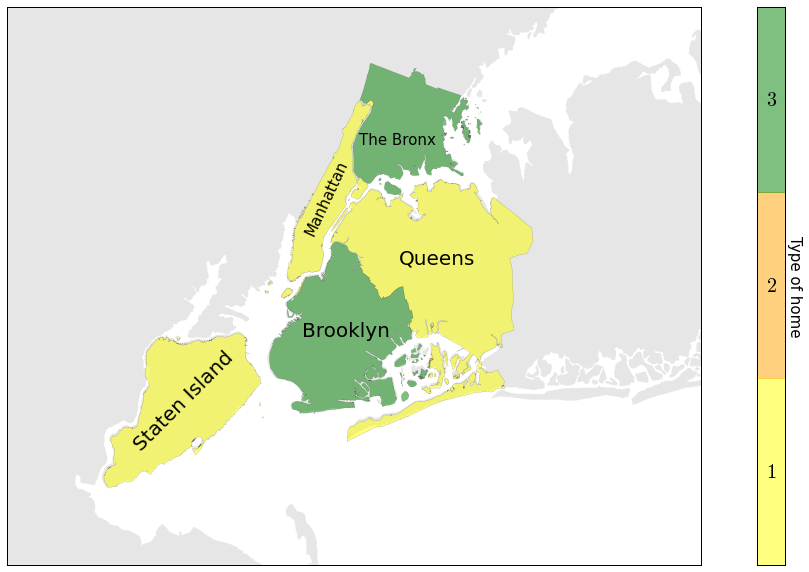

In [24]:
ax = plt.subplot(111)
m.fillcontinents(color='0.9')
m.readshapefile('files/nyc_detailed/nyc', 'NY', drawbounds=0)

patches = []
colors = []

for info, shape in zip(m.NY_info, m.NY):
    patches.append(Polygon(np.array(shape), True))
    colors.append(prices.loc[info['BoroName']].reset_index().values[0, 0])
    

p = PatchCollection(patches, cmap=clrs.ListedColormap(['yellow', 'orange', 'green']),
                    alpha=0.5, zorder=2, linewidth=0.2)
p.set_array(np.array(colors))
ax.add_collection(p)

cbar = plt.colorbar(p)
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$1$','$2$','$3$']):
    cbar.ax.text(.5, (2 * j + 1) / 6.0, lab,
                 ha='center', va='center', size=20)
cbar.ax.get_yaxis().labelpad = 17
cbar.ax.get_yaxis().label.set_size(15)
cbar.ax.set_ylabel('Type of home', rotation=270)

ax.text(32500, 43000, 'Manhattan', size=15, rotation=65)
ax.text(32500, 25000, 'Brooklyn', size=20)
ax.text(43000, 33000, 'Queens', size=20)
ax.text(38500, 46000, 'The Bronx', size=15)
ax.text(13500, 22000, 'Staten Island', size=20, rotation=45)

plt.show()

In [25]:
prices

,,MEDIAN SALE PRICE
District,TYPE OF HOME,
Bronx,2,416000
Brooklyn,2,631875
Manhattan,1,5260000
Queens,1,453750
Staten Island,1,395000


<br>

Рисуем на карту медианную сумму сделок по районам

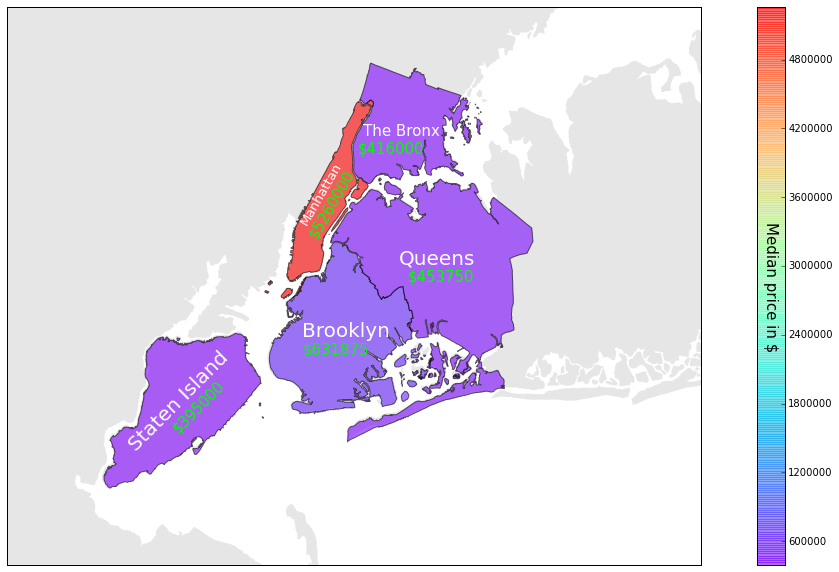

In [26]:
ax = plt.subplot(111)
m.fillcontinents(color='0.9')
m.readshapefile('files/nyc_detailed/nyc', 'NY', drawbounds=0)

patches = []
colors = []

for info, shape in zip(m.NY_info, m.NY):
    patches.append(Polygon(np.array(shape), True))
    colors.append(prices.loc[info['BoroName']].values[0, 0])
    

p = PatchCollection(patches, cmap=cm.rainbow, alpha=0.6, zorder=2)
p.set_array(np.array(colors))
ax.add_collection(p)

cbar = plt.colorbar(p)
cbar.ax.get_yaxis().labelpad = -55
cbar.ax.get_yaxis().label.set_size(15)
cbar.ax.set_ylabel('Median price in $', rotation=270)

ax.text(32000, 43000, 'Manhattan', size=13, rotation=60, color='w')
ax.text(33000, 42000, '$' + str(int(prices.loc['Manhattan'].values[0, 0])),
        size=15, rotation=60, color='lime')

ax.text(32500, 25000, 'Brooklyn', size=20, color='w')
ax.text(32500, 23000, '$' + str(int(prices.loc['Brooklyn'].values[0, 0])),
        size=15, color='lime')

ax.text(43000, 33000, 'Queens', size=20, color='w')
ax.text(44000, 31000, '$' + str(int(prices.loc['Queens'].values[0, 0])),
        size=15, color='lime')

ax.text(39000, 47000, 'The Bronx', size=15, color='w')
ax.text(38500, 45000, '$' + str(int(prices.loc['Bronx'].values[0, 0])),
        size=15, color='lime')

ax.text(13000, 22000, 'Staten Island', size=20, rotation=45, color='w')
ax.text(18000, 19000, '$' + str(int(prices.loc['Staten Island'].values[0, 0])),
        size=15, rotation=45, color='lime')


plt.show()